In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import functional as F

In [17]:
from naturalistic_image_embedder.third_party.equirectangular_toolbox.nfov import NFOV

In [4]:
hdr_dir = '../indoor_demo_dataset'
base_dir = '../demo_out'

hdr_crops_dir = os.path.join(base_dir, 'crops_hdr')
ldr_crops_dir = os.path.join(base_dir, 'crops_ldr')

In [9]:
hdr_img_path = os.path.join(hdr_dir, os.listdir(hdr_dir)[0])
hdr_images = [os.path.join(hdr_dir, image_name) for image_name in os.listdir(hdr_dir)]
print(img_path)
print(len(hdr_images))

../indoor_demo_dataset/AG8A5274-cf0cc6745e.exr
92


In [10]:
def gamma_correction(img, gamma=5):
    return np.clip(np.power(img, 1.0 / gamma), 0.0, 1.0).astype(np.float32)


def to_ldr(img_hdr, gamma=2.2):
    tonemap = cv2.createTonemapReinhard(gamma, 0, 0, 0)
    return (tonemap.process(img_hdr) * 255).astype(np.uint8)


def read_hdr(path):
    hdr_img = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
    return cv2.cvtColor(hdr_img, cv2.COLOR_BGR2RGB).astype('float32')


def write_hdr(path, hdr_img):
    hdr_bgr = cv2.cvtColor(hdr_img, cv2.COLOR_RGB2BGR).astype('float32')
    cv2.imwrite(path, hdr_bgr, [cv2.IMWRITE_EXR_TYPE_FLOAT])

In [29]:
def show_ldr(img):
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()  

def show_hdr(hdr_img):
    img = to_ldr(hdr_img.copy())
    show_ldr(img)

In [27]:
nfov = NFOV(height=1024, width=2048, FOV=[0.45, 0.45])
dsize = (512, 256)

def crop(img, point, dt='uint8'):
    cropped = nfov.toNFOV(img, point, dt)
    return cv2.resize(cropped, dsize).astype(dt)

n_crops = 4

def crop_points():
    w = np.random.random(size=(n_crops, 1))
    h = np.random.random(size=(n_crops, 1)) * 0.7
    return np.concatenate((w, h), axis=1)

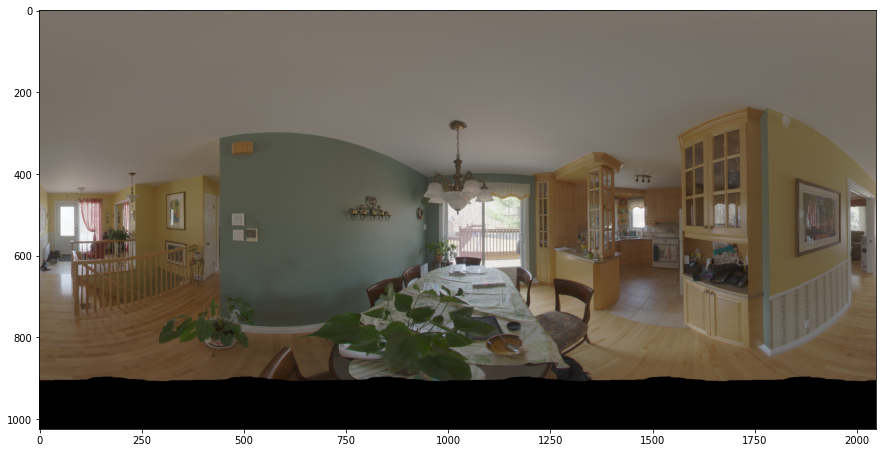

In [16]:
hdr_img = read_hdr(img_path)
show_hdr(hdr_img)

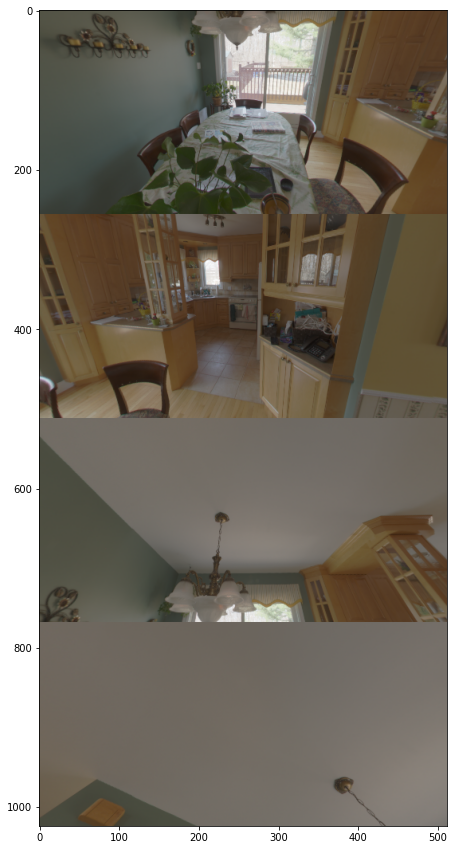

In [56]:
np.random.seed(1239)

# ldr_img = to_ldr(hdr_img)

points = crop_points()
cropped_hdrs = [crop(hdr_img.copy(), point, dt='float32') for point in points]

composed_crops = np.concatenate(cropped_hdrs, axis=0).astype('float32')
composed_crops_ldr = to_ldr(composed_crops)
show_hdr(composed_crops)

In [42]:
def to_pil(img):
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def from_pil(pil_img):
    img = np.array(pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [81]:
def adjust_image_param(img, func, lower_value, higher_value):
    original_image = to_pil(img)

    lower_param_image = func(original_contrast.copy(), lower_value)
    higher_param_image = func(original_contrast.copy(), higher_value)

    composed_contrast_adjusted = np.concatenate(
        list(map(from_pil, [lower_param_image, original_image, higher_param_image])),
        axis=1)
    show_ldr(composed_contrast_adjusted)

## Contrast

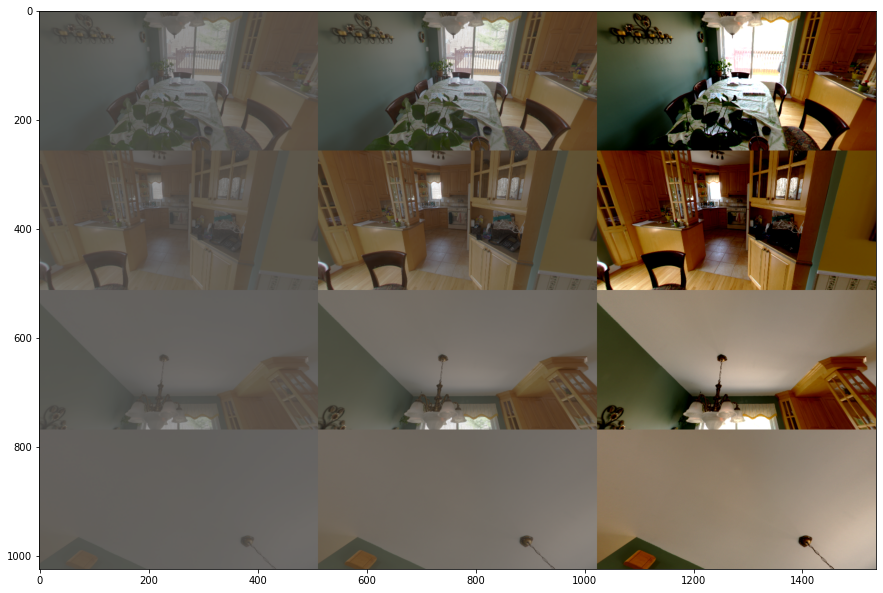

In [95]:
adjust_image_param(composed_crops_ldr.copy(), F.adjust_contrast, 0.4, 2.5)

## Brightness

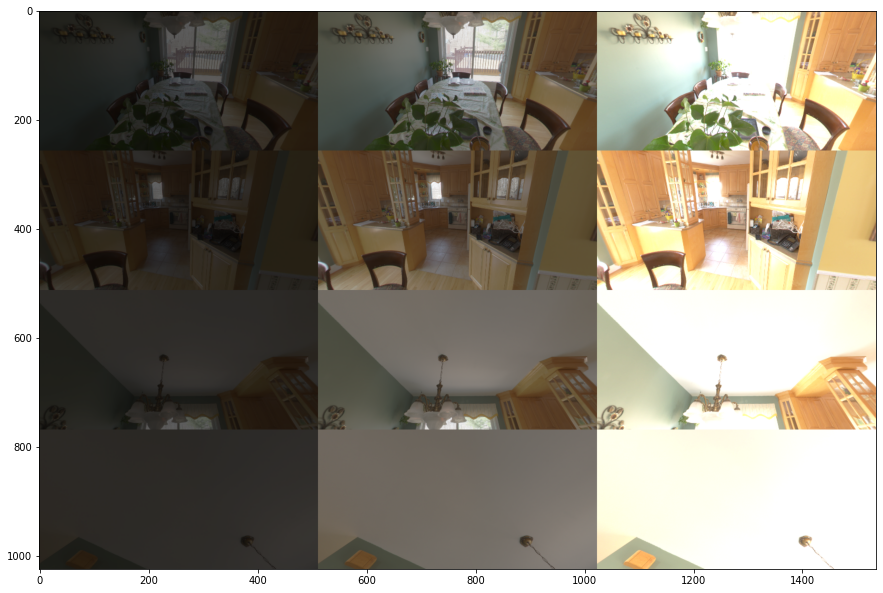

In [94]:
adjust_image_param(composed_crops_ldr.copy(), F.adjust_brightness, 0.4, 2.5)

## Gamma

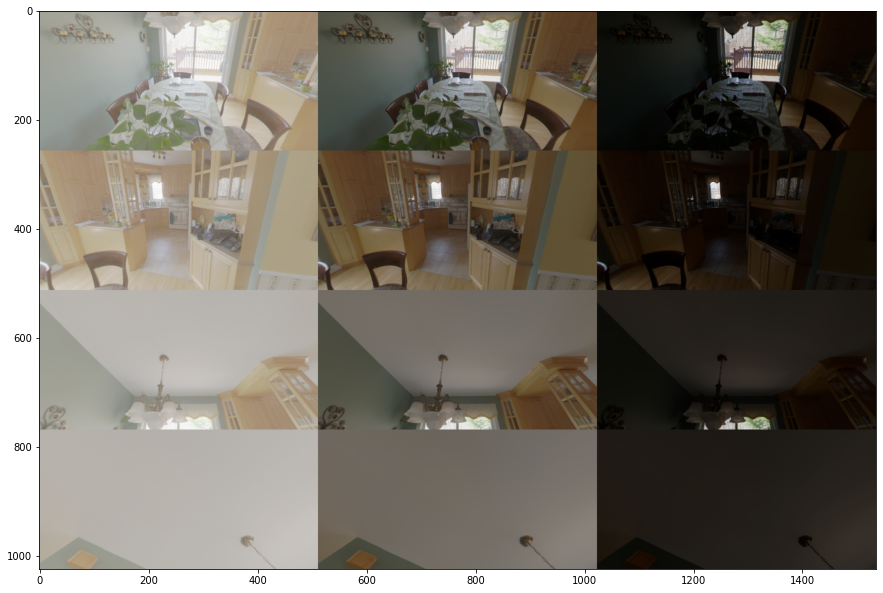

In [93]:
adjust_image_param(composed_crops_ldr.copy(), F.adjust_gamma, 0.4, 2.5)

## Saturation

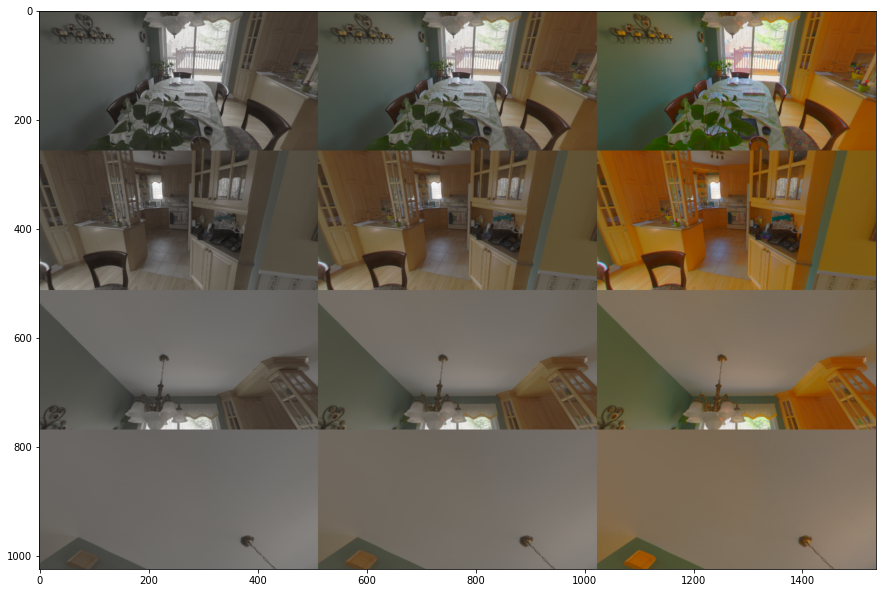

In [92]:
adjust_image_param(composed_crops_ldr.copy(), F.adjust_saturation, 0.4, 2.5)